# Projet apprentissage stat

**Objectif** : Prédire la variable $\texttt{Walc}$  

Méthodes de régression étudiées
* Régression linéaire
* KNN (pour une régression)
* splines 

source DB : https://www.kaggle.com/uciml/student-alcohol-consumption  
Etude sur les élèves du cours de portugais

**Données d'entrainement** : 500 étudiants  
**Données de test** : 149 étudiants

**Réduction de dimension** : on applique une ACP sur les données d'entrainement pour supprimer des variables quantitatives / on peut appliquer une MCA (Multiple correspondence analysis) qui traite les données qualitatives et quantitatives

In [244]:
rm(list=ls())
library(ISLR)
library(boot)
library (glmnet)
library(glmnetUtils)

# Observation des données

In [245]:
#d1=read.table("student-mat.csv",sep=",",header=TRUE)
d=read.table("student-por.csv",sep=",",header=TRUE)


In [246]:
n = dim(d)[1]
set.seed(2036125)
d = d[sample(1:n), ]

dim(d)
head(d)
indWalc = which("Walc"==colnames(d))

[1] 649  33

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
489,MS,F,19,U,GT3,T,1,1,at_home,services,...,5,3,1,1,1,3,6,7,9,9
135,GP,F,17,U,LE3,T,2,2,other,other,...,3,4,4,1,3,5,2,13,12,12
184,GP,F,16,U,GT3,T,4,4,health,health,...,4,4,2,1,1,3,0,16,16,17
265,GP,F,17,U,LE3,A,2,2,other,other,...,3,1,2,1,1,1,8,11,9,10
203,GP,F,17,U,GT3,A,3,3,health,other,...,3,3,3,1,3,3,10,12,13,14
229,GP,F,17,R,LE3,T,4,4,services,other,...,5,2,1,1,2,3,6,12,11,11


In [14]:
str(d)

'data.frame':	649 obs. of  33 variables:
 $ school    : Factor w/ 2 levels "GP","MS": 2 1 1 1 1 1 1 2 1 1 ...
 $ sex       : Factor w/ 2 levels "F","M": 1 1 1 1 1 1 2 1 2 2 ...
 $ age       : int  19 17 16 17 17 17 15 17 17 15 ...
 $ address   : Factor w/ 2 levels "R","U": 2 2 2 2 2 1 2 1 2 2 ...
 $ famsize   : Factor w/ 2 levels "GT3","LE3": 1 2 1 2 1 2 1 1 2 2 ...
 $ Pstatus   : Factor w/ 2 levels "A","T": 2 2 2 1 1 2 1 2 1 1 ...
 $ Medu      : int  1 2 4 2 3 4 2 1 3 3 ...
 $ Fedu      : int  1 2 4 2 3 4 2 1 2 2 ...
 $ Mjob      : Factor w/ 5 levels "at_home","health",..: 1 3 2 3 2 4 3 1 3 4 ...
 $ Fjob      : Factor w/ 5 levels "at_home","health",..: 4 3 2 3 3 3 3 1 3 3 ...
 $ reason    : Factor w/ 4 levels "course","home",..: 1 1 4 2 4 3 2 1 4 2 ...
 $ guardian  : Factor w/ 3 levels "father","mother",..: 2 1 2 2 2 2 3 1 2 2 ...
 $ traveltime: int  1 1 1 1 1 1 1 2 1 1 ...
 $ studytime : int  3 1 2 1 2 1 3 1 2 2 ...
 $ failures  : int  1 0 0 1 0 0 0 0 0 0 ...
 $ schoolsup : Factor w/

In [255]:
train = d[1:500,]
test = d[501:n,]

# Regression simple

In [257]:
lm.fit = lm(Walc~.,data=train)
y_pred=predict(lm.fit,test)
mean((y_pred-test$Walc)^2)

[1] 0.9516429

# Regression avec régularisation Elastic Net

In [258]:

x= model.matrix (Walc∼.,train)[,-1]
y= train$Walc

n_alpha = 21
grid.alpha = seq(0,1, length =n_alpha)
grid.lambda =10^ seq (3,-3, length =400)
set.seed(2036125)
cv.out.elastic = cva.glmnet(x,y,alpha = grid.alpha , lambda =grid.lambda,nfolds = 10)

In [259]:
formula
colnames(x)

function (x, ...) 
UseMethod("formula")
<bytecode: 0x000000004014f060>
<environment: namespace:stats>

[1] "schoolMS"         "sexM"             "age"              "addressU"        
 [5] "famsizeLE3"       "PstatusT"         "Medu"             "Fedu"            
 [9] "Mjobhealth"       "Mjobother"        "Mjobservices"     "Mjobteacher"     
[13] "Fjobhealth"       "Fjobother"        "Fjobservices"     "Fjobteacher"     
[17] "reasonhome"       "reasonother"      "reasonreputation" "guardianmother"  
[21] "guardianother"    "traveltime"       "studytime"        "failures"        
[25] "schoolsupyes"     "famsupyes"        "paidyes"          "activitiesyes"   
[29] "nurseryyes"       "higheryes"        "internetyes"      "romanticyes"     
[33] "famrel"           "freetime"         "goout"            "Dalc"            
[37] "health"           "absences"         "G1"               "G2"              
[41] "G3"

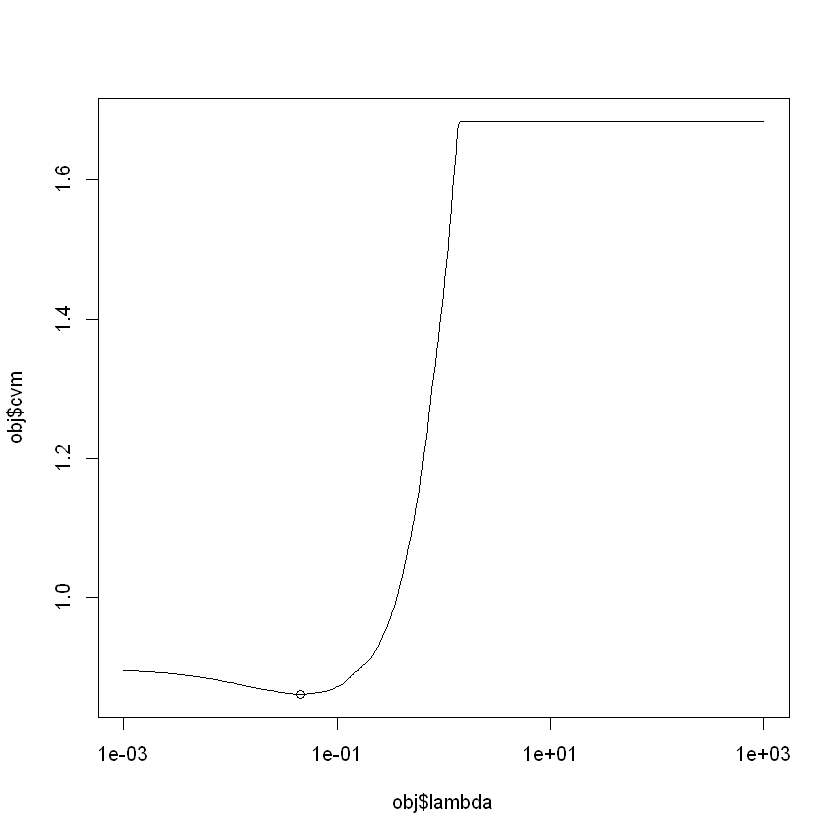

In [284]:
res.err = rep(0, n_alpha)
res.lambda = rep(0, n_alpha)

cpt = 1

for (obj in cv.out.elastic$modlist){
    
    res.err[cpt] = min(obj$cvm)
    truc = which.min(obj$cvm)
    res.lambda[cpt] = obj$lambda.min
    truc2 = obj$nzero[truc]
    cpt = cpt + 1
    if(cpt == 14){
        plot(x=obj$lambda,y=obj$cvm,type="l",log='x')
        points(x = obj$lambda[truc],y = obj$cvm[truc])
    }
    
}

best.index = which.min(res.err)
best.alpha = grid.alpha[best.index]
best.lambda = res.lambda[best.index]
best.err = res.err[best.index]

In [261]:
str(obj)

List of 11
 $ lambda    : num [1:400] 1000 966 933 901 871 ...
 $ cvm       : num [1:400] 1.68 1.68 1.68 1.68 1.68 ...
 $ cvsd      : num [1:400] 0.105 0.105 0.105 0.105 0.105 ...
 $ cvup      : num [1:400] 1.79 1.79 1.79 1.79 1.79 ...
 $ cvlo      : num [1:400] 1.58 1.58 1.58 1.58 1.58 ...
 $ nzero     : Named int [1:400] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:400] "s0" "s1" "s2" "s3" ...
 $ call      : language glmnet::cv.glmnet(x = x, y = y, lambda = ..1, nfolds = nfolds, foldid = foldid,      alpha = a)
 $ name      : Named chr "Mean-Squared Error"
  ..- attr(*, "names")= chr "mse"
 $ glmnet.fit:List of 12
  ..$ a0       : Named num [1:400] 2.31 2.31 2.31 2.31 2.31 ...
  .. ..- attr(*, "names")= chr [1:400] "s0" "s1" "s2" "s3" ...
  ..$ beta     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:4006] 35 35 35 35 35 35 35 35 35 35 ...
  .. .. ..@ p       : int [1:401] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..@ Dim     : int [1:2] 41 400


In [262]:
best.err 
best.lambda 
best.alpha 
best.index

[1] 0.8605404

[1] 0.04509572

[1] 0.6

[1] 13

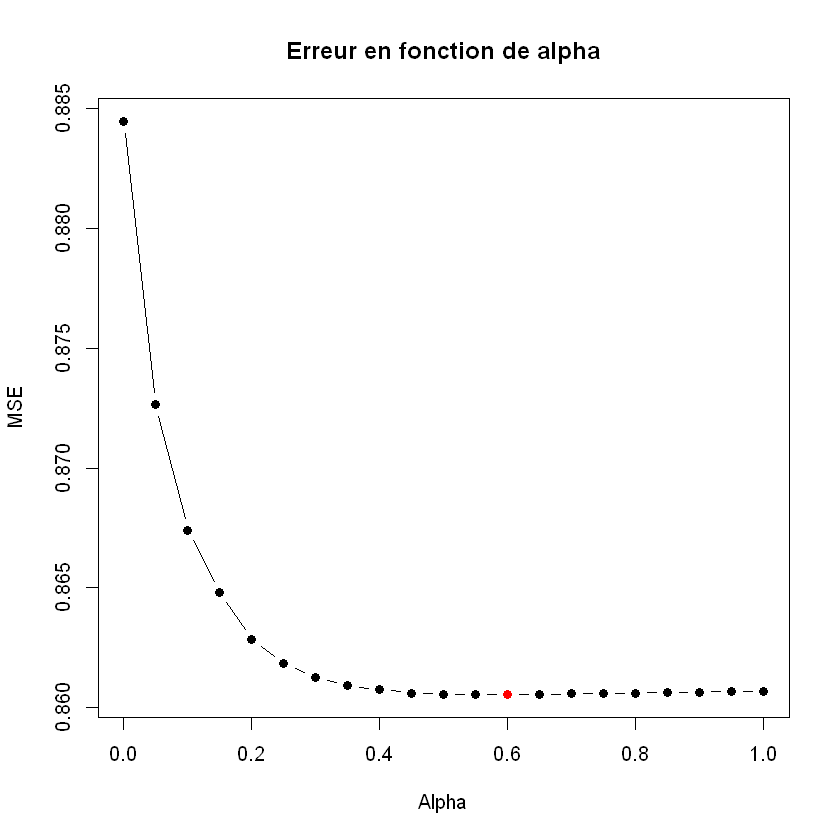

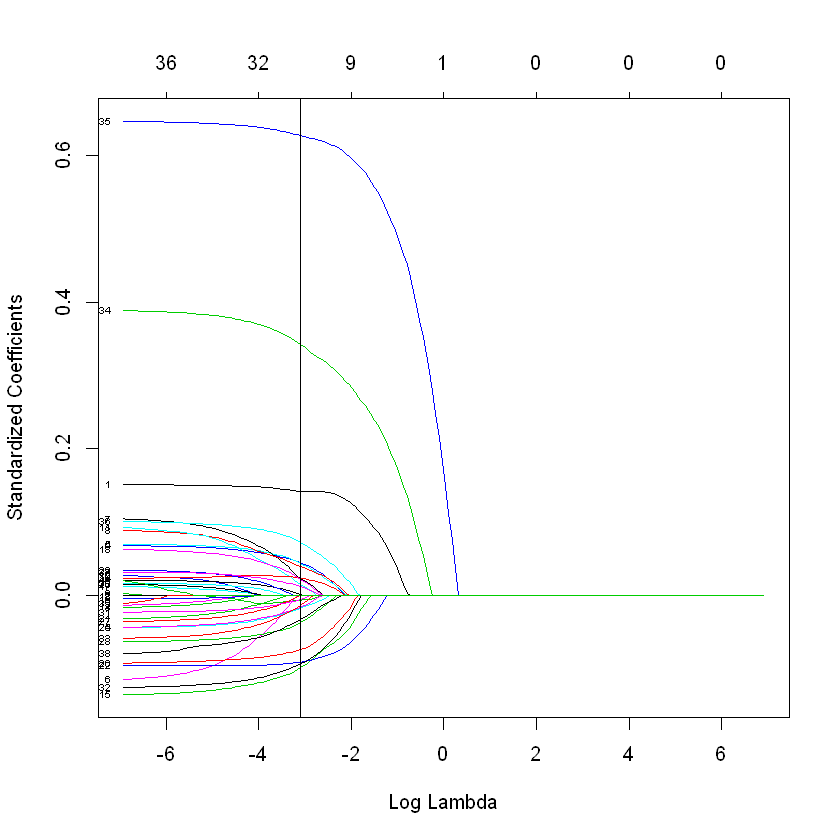

In [263]:

#plot(x=obj$lambda,y=obj$cvm,type="b")
plot(x = grid.alpha, y = res.err, pch=19, type="b", xlab = "Alpha", ylab = "MSE",
    main = "Erreur en fonction de alpha")

points(best.alpha, res.err[best.index], col="red", pch=19)
grid.lambda2 =10^ seq (3,-3, length =200)
x_scaled = scale(x[,-1])
model.elastic_scaled=glmnet(x_scaled,y,alpha =best.alpha , lambda =grid.lambda2, standardized = FALSE )

plot(model.elastic_scaled,xvar="lambda",label=TRUE,ylab ="Standardized Coefficients")
abline(v =log(best.lambda))

In [264]:
rownames(coef(model.elastic_scaled))[35]
rownames(coef(model.elastic_scaled))[34]
rownames(coef(model.elastic_scaled))[1]
length(rownames(coef(model.elastic_scaled)))
rownames(coef(model.elastic_scaled))
truc2

[1] "goout"

[1] "freetime"

[1] "(Intercept)"

[1] 41

[1] "(Intercept)"      "sexM"             "age"              "addressU"        
 [5] "famsizeLE3"       "PstatusT"         "Medu"             "Fedu"            
 [9] "Mjobhealth"       "Mjobother"        "Mjobservices"     "Mjobteacher"     
[13] "Fjobhealth"       "Fjobother"        "Fjobservices"     "Fjobteacher"     
[17] "reasonhome"       "reasonother"      "reasonreputation" "guardianmother"  
[21] "guardianother"    "traveltime"       "studytime"        "failures"        
[25] "schoolsupyes"     "famsupyes"        "paidyes"          "activitiesyes"   
[29] "nurseryyes"       "higheryes"        "internetyes"      "romanticyes"     
[33] "famrel"           "freetime"         "goout"            "Dalc"            
[37] "health"           "absences"         "G1"               "G2"              
[41] "G3"

s303 
  24

In [265]:
model.elastic = glmnet(x,y,alpha = best.lambda, lambda = best.lambda)
xtest = model.matrix (Walc∼.,test)[,-indWalc]
pred.elastic=predict(model.elastic,newx=xtest)
mean((pred.elastic-test$Walc)^2)


[1] 1.280657

In [266]:
result = cbind(pred.elastic,test$Walc)
colnames(result)[1] = "Prediction"
colnames(result)[2] = "True value"
head(result,15)

,Prediction,True value
547,3.723282,1
224,1.530154,1
558,1.593351,1
497,2.244611,2
98,2.137634,1
350,1.749272,2
133,1.551589,2
197,2.415238,3
644,3.102201,2
129,3.530058,5


# Spline (changer)

In [267]:
library (gam)

In [268]:
colnames(train)

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "guardian"   "traveltime" "studytime"  "failures"  
[16] "schoolsup"  "famsup"     "paid"       "activities" "nursery"   
[21] "higher"     "internet"   "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1"         "G2"         "G3"

In [269]:
quali = sapply(train, function(x) is.factor(x))
indWalc2 = which("Walc"==colnames(train[!quali]))
formula = as.formula(paste("Walc~", paste(names(train)[quali], collapse="+"),"+",paste("s(",names(train)[!quali][-indWalc2],", 2)", collapse="+")))

In [274]:
formula

Walc ~ school + sex + address + famsize + Pstatus + Mjob + Fjob + 
    reason + guardian + schoolsup + famsup + paid + activities + 
    nursery + higher + internet + romantic + s(age, 2) + s(Medu, 
    2) + s(Fedu, 2) + s(traveltime, 2) + s(studytime, 2) + s(failures, 
    2) + s(famrel, 2) + s(freetime, 2) + s(goout, 2) + s(Dalc, 
    2) + s(health, 2) + s(absences, 2) + s(G1, 2) + s(G2, 2) + 
    s(G3, 2)

In [271]:
library(gamclass)

In [275]:
gam.m=gam(formula,data=train)
pred.gam=predict(gam.m,test)
length(pred.gam)
length(test$Walc)
mean((pred.gam-test$Walc)^2)
summary(gam.m)

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

[1] 149

[1] 149

[1] 0.9919042


Call: gam(formula = formula, data = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-2.62486 -0.58601 -0.06384  0.51559  2.46923 

(Dispersion Parameter for gaussian family taken to be 0.7449)

    Null Deviance: 839.702 on 499 degrees of freedom
Residual Deviance: 329.985 on 443.0001 degrees of freedom
AIC: 1327.158 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                  Df Sum Sq Mean Sq  F value    Pr(>F)    
school             1   0.58   0.583   0.7832 0.3766560    
sex                1  77.66  77.655 104.2513 < 2.2e-16 ***
address            1   0.00   0.001   0.0015 0.9690561    
famsize            1   3.85   3.850   5.1692 0.0234683 *  
Pstatus            1   4.16   4.162   5.5876 0.0185187 *  
Mjob               4   3.62   0.905   1.2152 0.3035677    
Fjob               4  19.68   4.920   6.6057 3.600e-05 ***
reason             3   5.30   1.767   2.3724 0.0697455 .  
guardian           2   0.36   0.178   0.2395 0.787091

In [273]:
CVgam(formula, data=train, nfold = 10, method = "GCV.Cp",
              printit = TRUE, seed = 2036125)

ERROR: Error in terms.formula(reformulate(term[i])): formule de modèle incorrecte dans ExtractVars
